## Toxic: Word2Vec

In [1]:
import time

import numpy as np
import tensorflow as tf
import pandas as pd

import utils

/Users/brianmcmahon/anaconda3/envs/tensorflow1.4/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:
import pandas as pd
df = pd.read_pickle('../data/toxictrain.pkl')
df = df[df['rating']>0]
documents = [''.join(r) for r in df.comment_text]
text = ''.join(documents)

In [3]:
import re

text = re.sub('[^A-Za-z0-9 ]+', '',text)

In [4]:
words = utils.preprocess(text)
print(words[:30])

['i', 'hope', 'your', 'retarded', 'kids', 'get', 'anal', 'raped', 'and', 'murdered', 'for', 'having', 'such', 'a', 'fag', 'as', 'a', 'father', 'im', 'gonna', 'fuck', 'your', 'fat', 'wife', 'and', 'her', 'over', 'the', 'bridge', 'consider']


In [5]:
print("Total words: {}".format(len(words)))
print("Unique words: {}".format(len(set(words))))

Total words: 753193
Unique words: 6687


In [6]:
vocab_to_int, int_to_vocab = utils.create_lookup_tables(words)
int_words = [vocab_to_int[word] for word in words]

In [7]:
from collections import Counter
import random

threshold = 1e-5
word_counts = Counter(int_words)
total_count = len(int_words)
freqs = {word: count/total_count for word, count in word_counts.items()}
p_drop = {word: 1 - np.sqrt(threshold/freqs[word]) for word in word_counts}
train_words = [word for word in int_words if random.random() < (1 - p_drop[word])]

In [8]:
def get_target(words, idx, window_size=5):
    ''' Get a list of words in a window around an index. '''
    
    R = np.random.randint(1, window_size+1)
    start = idx - R if (idx - R) > 0 else 0
    stop = idx + R
    target_words = set(words[start:idx] + words[idx+1:stop+1])
    
    return list(target_words)

In [9]:
def get_batches(words, batch_size, window_size=5):
    ''' Create a generator of word batches as a tuple (inputs, targets) '''
    
    n_batches = len(words)//batch_size
    
    # only full batches
    words = words[:n_batches*batch_size]
    
    for idx in range(0, len(words), batch_size):
        x, y = [], []
        batch = words[idx:idx+batch_size]
        for ii in range(len(batch)):
            batch_x = batch[ii]
            batch_y = get_target(batch, ii, window_size)
            y.extend(batch_y)
            x.extend([batch_x]*len(batch_y))
        yield x, y
    

In [10]:
train_graph = tf.Graph()
with train_graph.as_default():
    inputs = tf.placeholder(tf.int32, [None], name='inputs')
    labels = tf.placeholder(tf.int32, [None, None], name='labels')

In [11]:
n_vocab = len(int_to_vocab)
n_embedding = 200 # Number of embedding features 
with train_graph.as_default():
    embedding = tf.Variable(tf.random_uniform((n_vocab, n_embedding), -1, 1))
    embed = tf.nn.embedding_lookup(embedding, inputs)

In [12]:
# Number of negative labels to sample
n_sampled = 100
with train_graph.as_default():
    softmax_w = tf.Variable(tf.truncated_normal((n_vocab, n_embedding), stddev=0.1))
    softmax_b = tf.Variable(tf.zeros(n_vocab))
    
    # Calculate the loss using negative sampling
    loss = tf.nn.sampled_softmax_loss(softmax_w, softmax_b, 
                                      labels, embed,
                                      n_sampled, n_vocab)
    
    cost = tf.reduce_mean(loss)
    optimizer = tf.train.AdamOptimizer().minimize(cost)

In [13]:
with train_graph.as_default():
    ## From Thushan Ganegedara's implementation
    valid_size = 16 # Random set of words to evaluate similarity on.
    valid_window = 100
    # pick 8 samples from (0,100) and (1000,1100) each ranges. lower id implies more frequent 
    valid_examples = np.array(random.sample(range(valid_window), valid_size//2))
    valid_examples = np.append(valid_examples, 
                               random.sample(range(1000,1000+valid_window), valid_size//2))

    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embedding), 1, keep_dims=True))
    normalized_embedding = embedding / norm
    valid_embedding = tf.nn.embedding_lookup(normalized_embedding, valid_dataset)
    similarity = tf.matmul(valid_embedding, tf.transpose(normalized_embedding))

In [14]:
# If the checkpoints directory doesn't exist:
# !mkdir checkpoints

In [15]:
epochs = 100
batch_size = 1000
window_size = 10

with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    iteration = 1
    loss = 0
    sess.run(tf.global_variables_initializer())

    for e in range(1, epochs+1):
        batches = get_batches(train_words, batch_size, window_size)
        start = time.time()
        for x, y in batches:
            
            feed = {inputs: x,
                    labels: np.array(y)[:, None]}
            train_loss, _ = sess.run([cost, optimizer], feed_dict=feed)
            
            loss += train_loss
            
            if iteration % 100 == 0: 
                end = time.time()
                print("Epoch {}/{}".format(e, epochs),
                      "Iteration: {}".format(iteration),
                      "Avg. Training loss: {:.4f}".format(loss/100),
                      "{:.4f} sec/batch".format((end-start)/100))
                loss = 0
                start = time.time()
            
            if iteration % 1000 == 0:
                # note that this is expensive (~20% slowdown if computed every 500 steps)
                sim = similarity.eval()
                for i in range(valid_size):
                    valid_word = int_to_vocab[valid_examples[i]]
                    top_k = 8 # number of nearest neighbors
                    nearest = (-sim[i, :]).argsort()[1:top_k+1]
                    log = 'Nearest to %s:' % valid_word
                    for k in range(top_k):
                        close_word = int_to_vocab[nearest[k]]
                        log = '%s %s,' % (log, close_word)
                    print(log)
            
            iteration += 1
    save_path = saver.save(sess, "../data/checkpoints/w2v_3.ckpt")
    embed_mat = sess.run(normalized_embedding)

Epoch 1/100 Iteration: 100 Avg. Training loss: 5.0328 0.2709 sec/batch
Epoch 2/100 Iteration: 200 Avg. Training loss: 4.9203 0.2235 sec/batch
Epoch 3/100 Iteration: 300 Avg. Training loss: 4.8295 0.1845 sec/batch
Epoch 4/100 Iteration: 400 Avg. Training loss: 4.7619 0.1481 sec/batch
Epoch 5/100 Iteration: 500 Avg. Training loss: 4.6651 0.1099 sec/batch
Epoch 6/100 Iteration: 600 Avg. Training loss: 4.5864 0.0740 sec/batch
Epoch 7/100 Iteration: 700 Avg. Training loss: 4.4735 0.0384 sec/batch
Epoch 8/100 Iteration: 800 Avg. Training loss: 4.4053 0.0051 sec/batch
Epoch 8/100 Iteration: 900 Avg. Training loss: 4.3022 0.2912 sec/batch
Epoch 9/100 Iteration: 1000 Avg. Training loss: 4.2263 0.2317 sec/batch
Nearest to been: officer, bicth, reject, ideology, stinky, aol, replace, stench,
Nearest to at: pursue, lose, supreme, nazi, bitchwhat, picking, require, ludicrous,
Nearest to wikipedia: siblings, environment, basement, annoy, barbarian, answering, sexuality, font,
Nearest to one: expose,

Epoch 36/100 Iteration: 4100 Avg. Training loss: 3.5437 0.2651 sec/batch
Epoch 37/100 Iteration: 4200 Avg. Training loss: 3.4577 0.2352 sec/batch
Epoch 38/100 Iteration: 4300 Avg. Training loss: 3.4419 0.2118 sec/batch
Epoch 39/100 Iteration: 4400 Avg. Training loss: 3.4508 0.1655 sec/batch
Epoch 40/100 Iteration: 4500 Avg. Training loss: 3.4371 0.1372 sec/batch
Epoch 41/100 Iteration: 4600 Avg. Training loss: 3.4210 0.1004 sec/batch
Epoch 42/100 Iteration: 4700 Avg. Training loss: 3.4093 0.0643 sec/batch
Epoch 43/100 Iteration: 4800 Avg. Training loss: 3.4101 0.0287 sec/batch
Epoch 43/100 Iteration: 4900 Avg. Training loss: 3.4639 0.2877 sec/batch
Epoch 44/100 Iteration: 5000 Avg. Training loss: 3.3840 0.2906 sec/batch
Nearest to been: replace, yet, graduate, sadly, officer, ahahahahahahahahahahahahahahahahahahaha, seeking, reject,
Nearest to at: picking, require, kerry, pedophile, pursue, major, told, andrew,
Nearest to wikipedia: environment, channel, font, theory, glad, eternal, di

Epoch 72/100 Iteration: 8100 Avg. Training loss: 3.2012 0.0134 sec/batch
Epoch 72/100 Iteration: 8200 Avg. Training loss: 3.1565 0.2509 sec/batch
Epoch 73/100 Iteration: 8300 Avg. Training loss: 3.1181 0.2311 sec/batch
Epoch 74/100 Iteration: 8400 Avg. Training loss: 3.1106 0.1895 sec/batch
Epoch 75/100 Iteration: 8500 Avg. Training loss: 3.1136 0.1596 sec/batch
Epoch 76/100 Iteration: 8600 Avg. Training loss: 3.1121 0.1197 sec/batch
Epoch 77/100 Iteration: 8700 Avg. Training loss: 3.1039 0.0793 sec/batch
Epoch 78/100 Iteration: 8800 Avg. Training loss: 3.1105 0.0469 sec/batch
Epoch 79/100 Iteration: 8900 Avg. Training loss: 3.1510 0.0161 sec/batch
Epoch 79/100 Iteration: 9000 Avg. Training loss: 3.1376 0.2601 sec/batch
Nearest to been: graduate, yet, sadly, chelsea, seeking, ahahahahahahahahahahahahahahahahahahaha, stench, probably,
Nearest to at: picking, require, kerry, major, victoria, domain, editing, kannadiga,
Nearest to wikipedia: environment, banana, message, theory, addresses

In [16]:
with train_graph.as_default():
    saver = tf.train.Saver()

with tf.Session(graph=train_graph) as sess:
    saver.restore(sess, tf.train.latest_checkpoint('../data/checkpoints'))
    embed_mat = sess.run(embedding)

INFO:tensorflow:Restoring parameters from ../data/checkpoints/w2v_3.ckpt


In [17]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [36]:
viz_words = 300
tsne = TSNE()
embed_tsne = tsne.fit_transform(embed_mat[:viz_words, :])

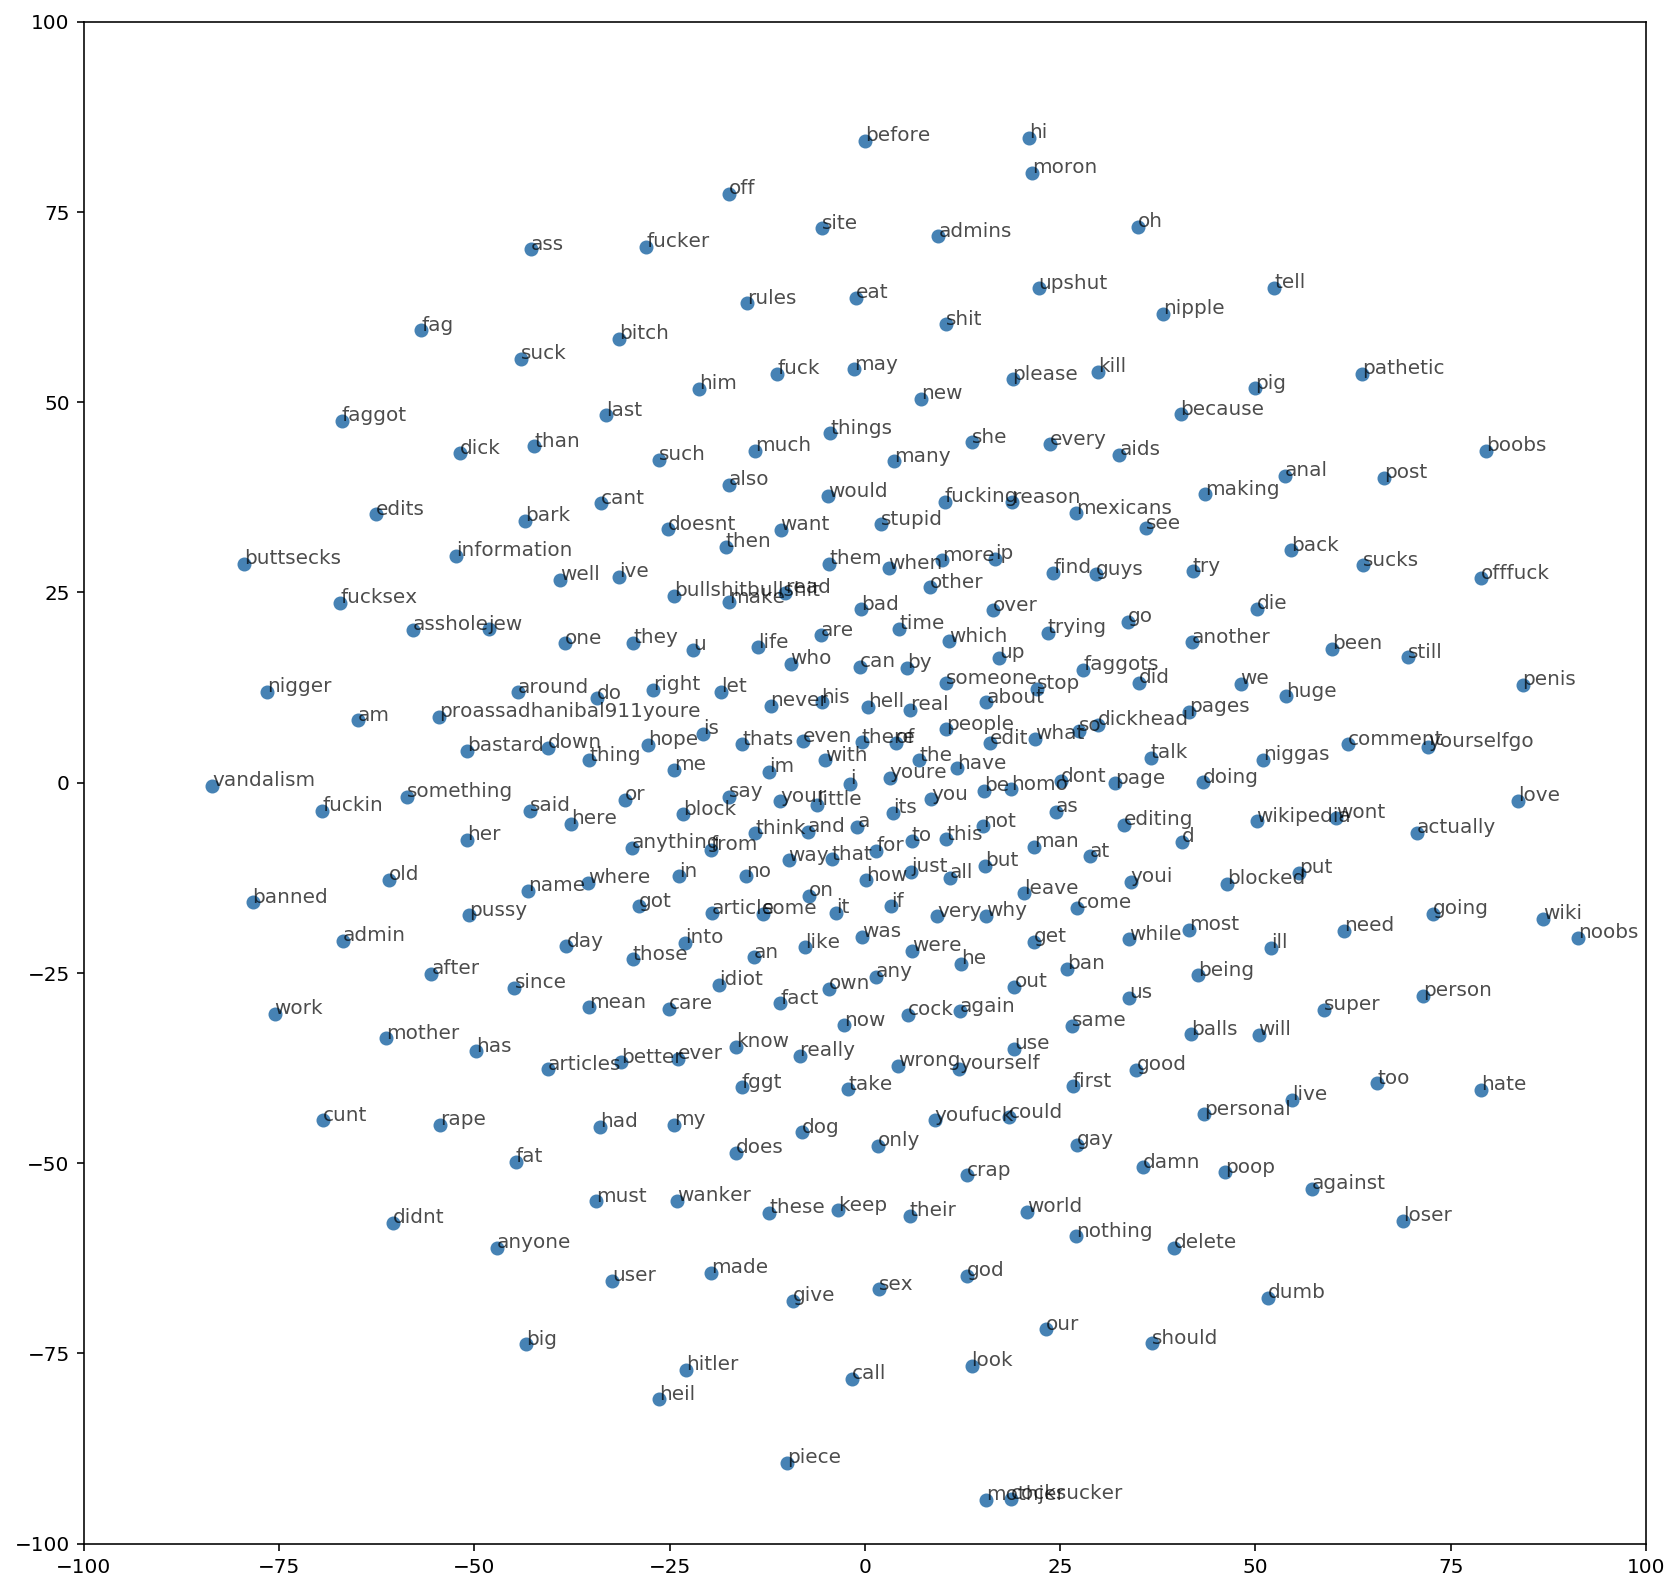

In [39]:
ax_set = 100.0
fig, ax = plt.subplots(figsize=(14, 14))
ax.axis([-ax_set,ax_set, -ax_set,ax_set])
ax = fig.gca()
ax.set_autoscale_on(False)

for idx in range(viz_words):
    plt.scatter(*embed_tsne[idx, :], color='steelblue')
    plt.annotate(int_to_vocab[idx], (embed_tsne[idx, 0], embed_tsne[idx, 1]), alpha=0.7)